<a href="https://colab.research.google.com/github/kaisarfardin6620/Text-Pair-Classification/blob/main/Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
import spacy
import string
import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
import tensorflow as tf
import os
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision


In [ ]:
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "4"
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "4"

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')

In [ ]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [ ]:
df.tail()

,id,premise,hypothesis,lang_abv,language,label
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2
12119,44301dfb14,"For himself he chose Atat??rk, or Father of th...",Ataturk was the father of the Turkish nation.,en,English,0


In [ ]:
df.shape

(12120, 6)

In [ ]:
df.describe()

,label
count,12120.000000
mean,0.990759
std,0.824523
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB


In [ ]:
df.isnull().sum()

,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.dtypes

,0
id,object
premise,object
hypothesis,object
lang_abv,object
language,object
label,int64


In [ ]:
df.nunique()

,0
id,12120
premise,8209
hypothesis,12119
lang_abv,15
language,15
label,3


In [ ]:
df.label.value_counts()

,count
label,
0,4176
2,4064
1,3880


In [ ]:
label_counts = df['label'].value_counts()

<ipython-input-18-af0d0f91fbb7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


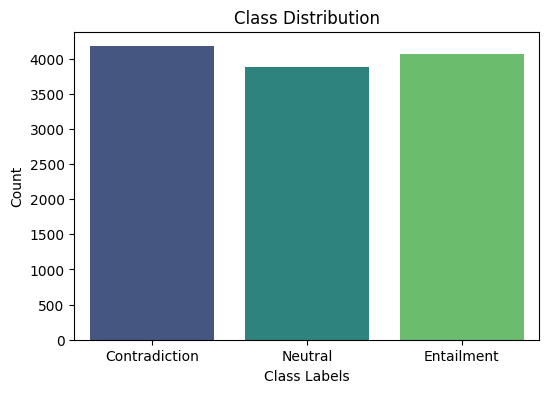

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(ticks=[0,1,2], labels=['Contradiction', 'Neutral', 'Entailment'])
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [ ]:
df['sentence1_length'] = df['premise'].apply(lambda x: len(x.split()))
df['sentence2_length'] = df['hypothesis'].apply(lambda x: len(x.split()))

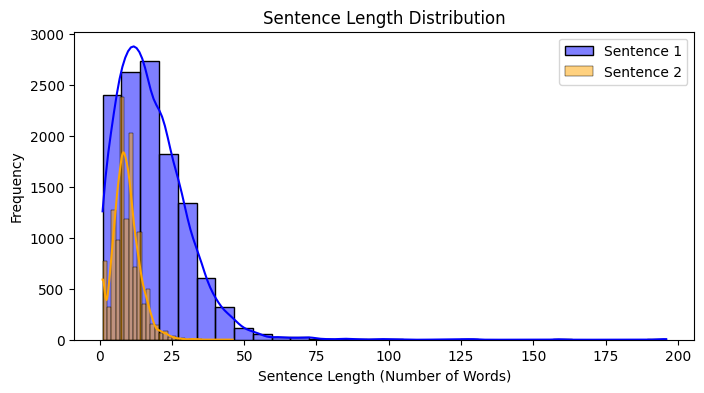

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['sentence1_length'], bins=30, kde=True, color='blue', label='Sentence 1')
sns.histplot(df['sentence2_length'], bins=30, kde=True, color='orange', label='Sentence 2')
plt.xlabel("Sentence Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.legend()
plt.show()

In [ ]:
def get_common_words(text_series, num_words=20):
    words = " ".join(text_series).split()
    common_words = Counter(words).most_common(num_words)
    return dict(common_words)

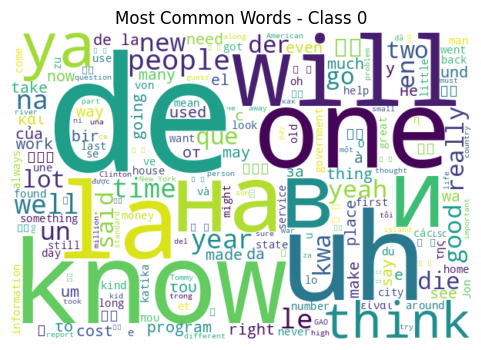

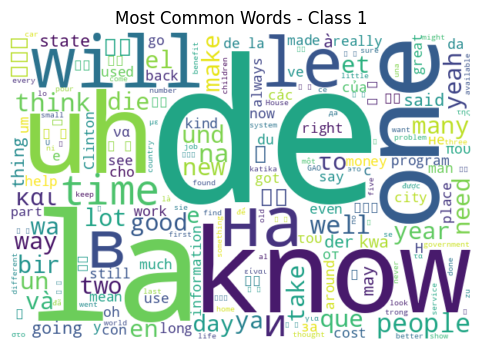

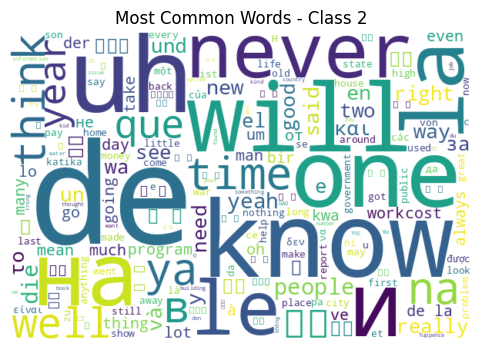

In [ ]:
for label, text_data in df.groupby("label"):
    words = " ".join(text_data["premise"]) + " " + " ".join(text_data["hypothesis"])
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(words)

    plt.figure(figsize=(6,4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Common Words - Class {label}")
    plt.show()

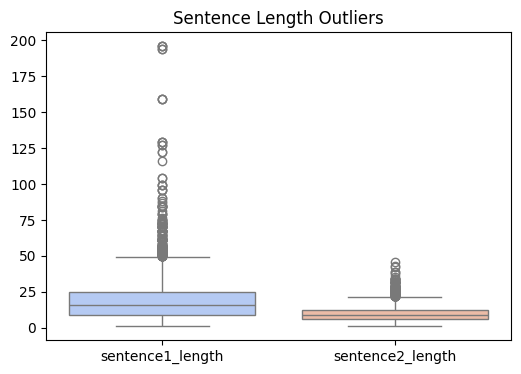

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df[['sentence1_length', 'sentence2_length']], palette="coolwarm")
plt.title("Sentence Length Outliers")
plt.show()

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
df = remove_outliers(df, 'sentence1_length')
df = remove_outliers(df, 'sentence2_length')

In [ ]:
print("Dataset size after outlier removal:", df.shape)

Dataset size after outlier removal: (11746, 8)


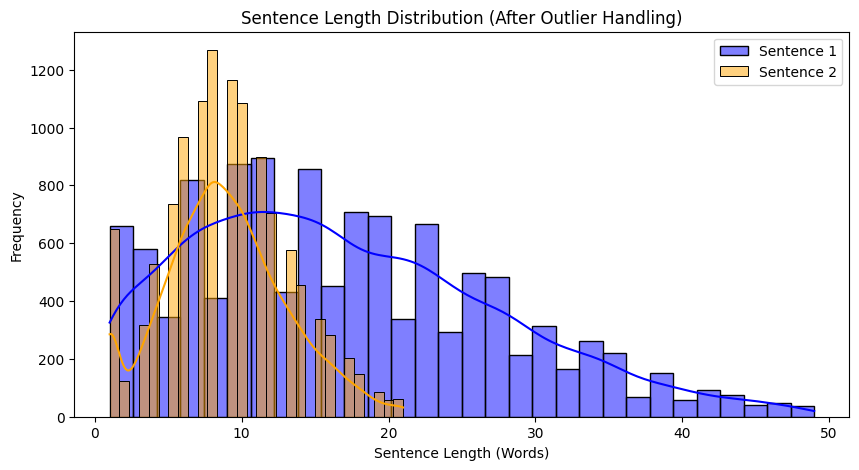

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['sentence1_length'], bins=30, kde=True, color='blue', label='Sentence 1')
sns.histplot(df['sentence2_length'], bins=30, kde=True, color='orange', label='Sentence 2')
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution (After Outlier Handling)")
plt.legend()
plt.show()


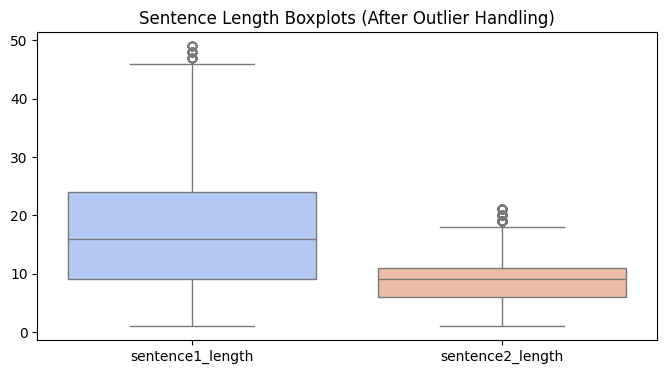

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df[['sentence1_length', 'sentence2_length']], palette="coolwarm")
plt.title("Sentence Length Boxplots (After Outlier Handling)")
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df['sentence1_clean'] = df['premise'].apply(clean_text)
df['sentence2_clean'] = df['hypothesis'].apply(clean_text)

In [ ]:
def spacy_tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

In [ ]:
df['sentence1_tokens'] = df['sentence1_clean'].apply(spacy_tokenize)
df['sentence2_tokens'] = df['sentence2_clean'].apply(spacy_tokenize)

In [ ]:
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return " ".join(tokens)

In [ ]:
df['sentence1_clean'] = df['sentence1_clean'].apply(remove_stopwords)
df['sentence2_clean'] = df['sentence2_clean'].apply(remove_stopwords)

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [ ]:
df['sentence1_clean'] = df['sentence1_clean'].apply(lemmatize_text)
df['sentence2_clean'] = df['sentence2_clean'].apply(lemmatize_text)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
df['sentence1_tokens'] = df['premise'].apply(lambda x: tokenizer.tokenize(x))
df['sentence2_tokens'] = df['hypothesis'].apply(lambda x: tokenizer.tokenize(x))

In [ ]:
print(df[['sentence1_clean', 'sentence2_clean']].head())

                                     sentence1_clean  \
0            comment consider formulate interim rule   
1          issue wrestle practice group law firm say   
2  des petites chose comme celle la font une diff...   
3  know t defend like somebody grow uh age know yeah   
4  ainkaarelnbthbaathsmmutikechnkan o kaasthiicch...   

                                     sentence2_clean  
0                  rule develop interim comment mind  
1                   practice group permit work issue  
2              j essayais d accomplir quelque choose  
3                                       t defend age  
4  edksaamaarthehnaidwaachaatiphanthuaetktaangkan...  


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [ ]:
X1_tfidf = tfidf_vectorizer.fit_transform(df['sentence1_clean'])
X2_tfidf = tfidf_vectorizer.transform(df['sentence2_clean'])

In [ ]:
X1_tfidf = X1_tfidf.toarray()
X2_tfidf = X2_tfidf.toarray()

In [ ]:
X_tfidf = np.hstack((X1_tfidf, X2_tfidf))

In [ ]:
print("TF-IDF Feature Shape:", X_tfidf.shape)

TF-IDF Feature Shape: (11746, 10000)


In [ ]:
df['sentence1_tokens'] = df['sentence1_clean'].apply(lambda x: x.split())
df['sentence2_tokens'] = df['sentence2_clean'].apply(lambda x: x.split())

In [ ]:
all_sentences = df['sentence1_tokens'].tolist() + df['sentence2_tokens'].tolist()

In [ ]:
w2v_model = Word2Vec(sentences=all_sentences, vector_size=300, window=5, min_count=2, workers=4)

In [ ]:
def get_sentence_embedding(sentence, model, vector_size=300):
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(vector_size)

In [ ]:
X1_w2v = np.array([get_sentence_embedding(sentence, w2v_model) for sentence in df['sentence1_tokens']])
X2_w2v = np.array([get_sentence_embedding(sentence, w2v_model) for sentence in df['sentence2_tokens']])

In [ ]:
X_w2v = np.hstack((X1_w2v, X2_w2v))

In [ ]:
print("Word2Vec Feature Shape:", X_w2v.shape)

Word2Vec Feature Shape: (11746, 600)


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X1_bert = []
X2_bert = []

In [ ]:
tokenized_data = {
    "X1": X1_bert,
    "X2": X2_bert
}

with open("tokenized_data.pkl", "wb") as f:
    pickle.dump(tokenized_data, f)

with open("tokenized_data.pkl", "rb") as f:
    tokenized_data = pickle.load(f)

X1_bert = np.array(tokenized_data["X1"])
X2_bert = np.array(tokenized_data["X2"])

In [ ]:
X_bert = np.hstack([X1_bert, X2_bert])

In [ ]:
#def get_bert_embedding(text):
 #   inputs = tokenizer(text, return_tensors="tf")
  #  outputs = model(**inputs)
   # embeddings = outputs.last_hidden_state[:, 0, :]
    #return embeddings.numpy()

#df['sentence1_bert'] = df['sentence1_clean'].apply(get_bert_embedding)
#df['sentence2_bert'] = df['sentence2_clean'].apply(get_bert_embedding)

#X1_bert = np.vstack(df['sentence1_bert'].values.tolist())
#X2_bert = np.vstack(df['sentence2_bert'].values.tolist())

In [ ]:
#tokenized_data = {
 #   "X1": X1_bert,
  #  "X2": X2_bert
#}

#with open("tokenized_data.pkl", "wb") as f:
 #   pickle.dump(tokenized_data, f)

#with open("tokenized_data.pkl", "rb") as f:
 #   tokenized_data = pickle.load(f)

#X1_bert = np.array(tokenized_data["X1"])
#X2_bert = np.array(tokenized_data["X2"])

In [ ]:
#X_bert_reshaped = X_bert.reshape(X_bert.shape[0], -1)

In [ ]:
#print("BERT Feature Shape:", X_bert.shape)

In [ ]:
x = np.hstack((X_tfidf, X_w2v))
#x = np.hstack((X_tfidf, X_w2v, X_bert_reshaped))

In [ ]:
y = df['label']

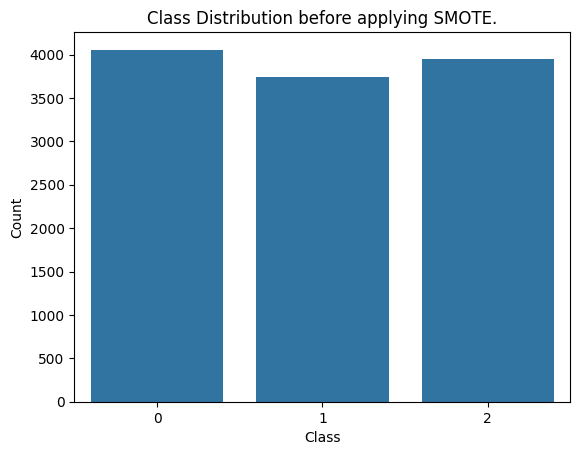

In [ ]:
sns.countplot(x=y)
plt.title("Class Distribution before applying SMOTE.")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

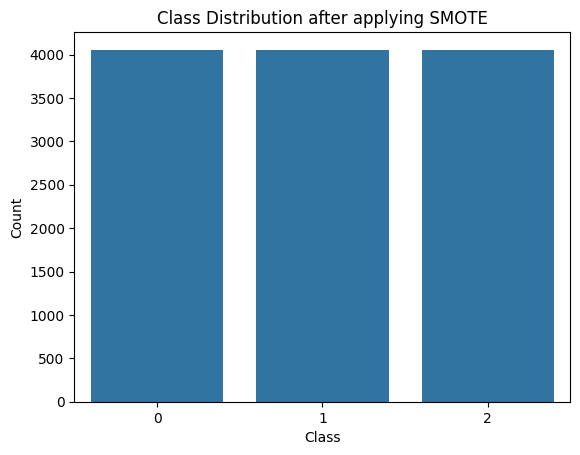

In [ ]:
sns.countplot(x=y_resampled)
plt.title("Class Distribution after applying SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.36647493837304845
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       788
           1       0.38      0.40      0.39       839
           2       0.37      0.28      0.32       807

    accuracy                           0.37      2434
   macro avg       0.37      0.37      0.36      2434
weighted avg       0.37      0.37      0.36      2434



In [ ]:
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(x_train, y_train)

y_pred_dt = dt_model.predict(x_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.36524239934264585
              precision    recall  f1-score   support

           0       0.39      0.08      0.13       788
           1       0.35      0.91      0.51       839
           2       0.54      0.08      0.14       807

    accuracy                           0.37      2434
   macro avg       0.43      0.36      0.26      2434
weighted avg       0.43      0.37      0.27      2434



In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(x_train, y_train)

y_pred_xgb = xgb_model.predict(x_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.38126540673788
              precision    recall  f1-score   support

           0       0.35      0.43      0.38       788
           1       0.41      0.38      0.40       839
           2       0.40      0.33      0.36       807

    accuracy                           0.38      2434
   macro avg       0.39      0.38      0.38      2434
weighted avg       0.39      0.38      0.38      2434



In [ ]:
ann_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: Contradiction, Neutral, Entailment
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
ann_model.fit(x_train, y_train, epochs=20, batch_size=8, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 149s 121ms/step - accuracy: 0.3164 - loss: 1.1229 - val_accuracy: 0.3443 - val_loss: 1.1005
Epoch 2/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 181s 104ms/step - accuracy: 0.3552 - loss: 1.1004 - val_accuracy: 0.3353 - val_loss: 1.0989
Epoch 3/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 125s 103ms/step - accuracy: 0.3467 - loss: 1.0981 - val_accuracy: 0.3274 - val_loss: 1.0989
Epoch 4/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 124s 102ms/step - accuracy: 0.3466 - loss: 1.0985 - val_accuracy: 0.3295 - val_loss: 1.0978
Epoch 5/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 142s 101ms/step - accuracy: 0.3520 - loss: 1.0991 - val_accuracy: 0.3311 - val_loss: 1.0987
Epoch 6/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 144s 103ms/step - accuracy: 0.3644 - loss: 1.0947 - val_accuracy: 0.3422 - val_loss: 1.0986
Epoch 7/20
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - accuracy: 0.3819 - loss: 1.0904 - val_accuracy: 0.3299 - val_loss: 1.1036


In [ ]:
y_pred_ann = ann_model.predict(x_test).argmax(axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [ ]:
print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann))

ANN Accuracy: 0.3294987674609696
              precision    recall  f1-score   support

           0       0.33      0.89      0.48       788
           1       0.00      0.00      0.00       839
           2       0.36      0.13      0.19       807

    accuracy                           0.33      2434
   macro avg       0.23      0.34      0.22      2434
weighted avg       0.22      0.33      0.22      2434



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
lstm_model = tf.keras.Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=x_train.shape[1]),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
lstm_model.fit(x_train, y_train,  batch_size=8, validation_data=(x_test, y_test))
#lstm_model.fit(x_train, y_train, epochs=20, batch_size=8, validation_data=(x_test, y_test), callbacks=[early_stopping])

  70/1217 ━━━━━━━━━━━━━━━━━━━━ 32:42:06 103s/step - accuracy: 0.3215 - loss: 1.1102

In [ ]:
y_pred_lstm = lstm_model.predict(x_test).argmax(axis=1)

In [ ]:
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))

In [ ]:
#bert_model = TFBertModel.from_pretrained("bert-base-uncased")
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
#def bert_encode(texts, tokenizer, max_length=128):
 #   return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

In [ ]:
#train_encodings = bert_encode(df['sentence1_clean'] + " " + df['sentence2_clean'], tokenizer)
#x_train, x_test, y_train, y_test = train_test_split(train_encodings['input_ids'], df['label'], test_size=0.2, random_state=42)

In [ ]:
#input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
#bert_output = bert_model(input_ids)[1]  # Pooled output
#dense = Dense(128, activation='relu')(bert_output)
#output = Dense(3, activation='softmax')(dense)

In [ ]:
#bert_classifier = Model(inputs=input_ids, outputs=output)
#bert_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
#bert_classifier.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=8, callbacks=[early_stopping])

In [ ]:
#y_pred_bert = bert_classifier.predict(x_test).argmax(axis=1)

In [ ]:
#print("BERT Fine-Tuning Accuracy:", accuracy_score(y_test, y_pred_bert))
#print(classification_report(y_test, y_pred_bert))

In [ ]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n📊 Evaluation Results for {model_name}:\n")

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
    from sklearn.preprocessing import label_binarize # Import label_binarize here
    import matplotlib.pyplot as plt
    import seaborn as sns

    accuracy = accuracy_score(y_true, y_pred)  # y_true and y_pred are passed as arguments to the function
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

    # Creating the confusion matrix inside the function
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Contradiction", "Neutral", "Entailment"], yticklabels=["Contradiction", "Neutral", "Entailment"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print("\n🔎 Classification Report:\n", classification_report(y_true, y_pred, target_names=["Contradiction", "Neutral", "Entailment"]))

    # Check if y_proba is provided and not None before plotting ROC curve
    if y_proba is not None:
        # Ensure y_true is binary for ROC curve
        y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
        plt.figure(figsize=(8, 6))

        for i, label in enumerate(["Contradiction", "Neutral", "Entailment"]):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"AUC-ROC Curve - {model_name}")
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
y_pred_rf = rf_model.predict(x_test)
y_proba_rf = rf_model.predict_proba(x_test) if hasattr(rf_model, "predict_proba") else None
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")

In [ ]:
y_pred_dt = dt_model.predict(x_test)
y_proba_dt = dt_model.predict_proba(x_test) if hasattr(dt_model, "predict_proba") else None
evaluate_model(y_test, y_pred_dt, y_proba_dt, "Decision Tree")

In [ ]:
y_pred_xgb = xgb_model.predict(x_test)
y_proba_xgb = xgb_model.predict_proba(x_test) if hasattr(xgb_model, "predict_proba") else None
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")

In [ ]:
y_proba_ann = ann_model.predict(x_test) # Get probabilities
y_pred_ann = y_proba_ann.argmax(axis=1)  # Get class labels
evaluate_model(y_test, y_pred_ann, y_proba_ann, "Artificial Neural Network")

In [ ]:
y_proba_lstm = lstm_model.predict(x_test) # Get probabilities
y_pred_lstm = y_proba_lstm.argmax(axis=1)  # Get class labels
evaluate_model(y_test, y_pred_lstm, y_proba_lstm, "LSTM")

In [ ]:
#y_pred_bert = bert_model.predict(x_test)
#y_pred_bert = y_pred_bert.argmax(axis=1)
#evaluate_model(y_test, y_pred_bert, None, "Fine-Tuned BERT")

In [ ]:
!pip install optuna

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import optuna


In [ ]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(x_train, y_train)

In [ ]:
print("🌟 Best Parameters for Decision Tree:", grid_search_dt.best_params_)
dt_model = grid_search_dt.best_estimator_

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_rf.fit(x_train, y_train)

In [ ]:
print("🌟 Best Parameters for Random Forest:", random_search_rf.best_params_)
rf_model = random_search_rf.best_estimator_

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [ ]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(x_train, y_train)

In [ ]:
print("🌟 Best Parameters for XGBoost:", grid_search_xgb.best_params_)
xgb_model = grid_search_xgb.best_estimator_

In [ ]:
def objective(trial):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(trial.suggest_int('units1', 64, 256), activation='relu'),
        tf.keras.layers.Dropout(trial.suggest_float('dropout1', 0.2, 0.5)),
        tf.keras.layers.Dense(trial.suggest_int('units2', 32, 128), activation='relu'),
        tf.keras.layers.Dropout(trial.suggest_float('dropout2', 0.2, 0.5)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

In [ ]:
    model.compile(
        optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    return max(history.history['val_accuracy'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
print("🌟 Best Parameters for ANN:", study.best_params_)

In [ ]:
def objective_lstm(trial):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=trial.suggest_int('embedding_dim', 50, 300)),
        tf.keras.layers.LSTM(trial.suggest_int('lstm_units', 50, 200), return_sequences=True),
        tf.keras.layers.Dropout(trial.suggest_float('dropout', 0.2, 0.5)),
        tf.keras.layers.LSTM(trial.suggest_int('lstm_units_2', 50, 200)),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

In [ ]:
    model.compile(
        optimizer=Adam(learning_rate=trial.suggest_loguniform('lr', 1e-4, 1e-2)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=trial.suggest_int('batch_size', 16, 64), verbose=0)
    return max(history.history['val_accuracy'])

In [ ]:
study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(objective_lstm, n_trials=20)

In [ ]:
print("🌟 Best Parameters for LSTM:", study_lstm.best_params_)

In [ ]:
#from transformers import TFBertForSequenceClassification, BertTokenizer
#import tensorflow as tf

In [ ]:
#bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

In [ ]:
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
"""def fine_tune_bert(learning_rate, batch_size):
    optimizer = Adam(learning_rate=learning_rate)
    bert_model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
#history = bert_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=batch_size)
#return max(history.history['val_accuracy'])

In [ ]:
#study_bert = optuna.create_study(direction='maximize')
#study_bert.optimize(lambda trial: fine_tune_bert(trial.suggest_loguniform('lr', 1e-5, 5e-5), trial.suggest_int('batch_size', 8, 32)), n_trials=10)

In [ ]:
#print("🌟 Best Parameters for BERT:", study_bert.best_params_)

In [ ]:
model_results = {
    "Model": ["Decision Tree", "Random Forest", "XGBoost", "Artificial Neural Network", "LSTM", "Fine-Tuned BERT"],
    "Accuracy": [dt_accuracy, rf_accuracy, xgb_accuracy, ann_accuracy, lstm_accuracy, bert_accuracy],
    "Precision": [dt_precision, rf_precision, xgb_precision, ann_precision, lstm_precision, bert_precision],
    "Recall": [dt_recall, rf_recall, xgb_recall, ann_recall, lstm_recall, bert_recall],
    "F1 Score": [dt_f1, rf_f1, xgb_f1, ann_f1, lstm_f1, bert_f1],
}

In [ ]:
df_results = pd.DataFrame(model_results)

In [ ]:
df_results = df_results.sort_values(by="Accuracy", ascending=False)

In [ ]:
print("📊 Model Performance Comparison:\n", df_results)

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(df_results["Model"], df_results["Accuracy"], color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy Comparison")
plt.gca().invert_yaxis()
plt.show()
